In [20]:
#CNN

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, GlobalMaxPooling1D, Concatenate
from sklearn.metrics import classification_report
import numpy as np
import joblib
from tensorflow.keras.models import save_model

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Add URL length as a feature
dataset['length_url'] = dataset['url'].apply(len)
# Add hostname length as a feature
dataset['length_hostname'] = dataset['url'].apply(lambda x: len(x.split('//')[-1].split('/')[0]))

# Extract numerical features including IP address presence, DNS record presence, and Google index presence
dataset['ip'] = dataset['ip']
dataset['dns_record'] = dataset['dns_record']
dataset['google_index'] = dataset['google_index']

# Encode categorical labels
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Text preprocessing
texts = dataset['url'].values  # Assuming 'url' is the text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_text_length = max([len(seq) for seq in sequences])
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_text_length, 'max_text_length.pkl')

# Padding sequences
X_text = pad_sequences(sequences, maxlen=max_text_length, padding='post')

# Extract numerical features
X_num = dataset[['length_url', 'length_hostname', 'ip', 'dns_record', 'google_index']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Split features and labels
y = dataset['status']
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

# Define CNN model for textual features
input_text = Input(shape=(max_text_length,))
embedding_layer = Embedding(vocab_size, 100)(input_text)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Define dense layer for numerical features
input_num = Input(shape=(X_train_num.shape[1],))
dense_layer = Dense(64, activation='relu')(input_num)

# Concatenate text and numerical features
concatenated = Concatenate()([pooling_layer, dense_layer])
output = Dense(1, activation='sigmoid')(concatenated)

# Define combined model
model = Model(inputs=[input_text, input_num], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit([X_train_text, X_train_num], y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions for test set
y_pred_probs = model.predict([X_test_text, X_test_num])
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Save the trained model
save_model(model, 'cnn.h5')


Epoch 1/100
129/129 [==============================] - 21s 148ms/step - loss: 0.3294 - accuracy: 0.8926 - val_loss: 0.1736 - val_accuracy: 0.9366
Epoch 2/100
129/129 [==============================] - 16s 122ms/step - loss: 0.0750 - accuracy: 0.9782 - val_loss: 0.1285 - val_accuracy: 0.9552
Epoch 3/100
129/129 [==============================] - 13s 99ms/step - loss: 0.0135 - accuracy: 0.9973 - val_loss: 0.1344 - val_accuracy: 0.9639
Epoch 4/100
129/129 [==============================] - 11s 88ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1349 - val_accuracy: 0.9617
Epoch 5/100
129/129 [==============================] - 12s 91ms/step - loss: 9.2419e-04 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9628
Epoch 6/100
129/129 [==============================] - 12s 97ms/step - loss: 5.4802e-04 - accuracy: 1.0000 - val_loss: 0.1434 - val_accuracy: 0.9607
Epoch 7/100
129/129 [==============================] - 13s 97ms/step - loss: 3.7064e-04 - accuracy: 1.0000 - val_loss: 0

<ipython-input-20-275c88397454>:99: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'cnn.h5')


Checking the CNN model


In [36]:
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import pandas as pd

# Load the label encoder, tokenizer, max_text_length, and scaler
label_encoder = joblib.load('label_encoder.pkl')
tokenizer = joblib.load('tokenizer.pkl')
max_text_length = joblib.load('max_text_length.pkl')
scaler = joblib.load('scaler.pkl')

# Load the trained model
model = load_model('cnn.h5')

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Function to check URL
def check_url(url):
    # Check if the URL is in the dataset
    if url in dataset['url'].values:
        # Get features from the dataset
        data_row = dataset[dataset['url'] == url].iloc[0]
        ip_present = data_row['ip']
        dns_record = data_row['dns_record']
        google_index = data_row['google_index']
    else:
        # Compute features based on the URL
        ip_present = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) is not None else 0
        dns_record = 1 if 'dns' in url else 0
        google_index = 1 if 'google' in url else 0

    # Tokenize and pad the test URL
    test_sequence = tokenizer.texts_to_sequences([url])
    test_sequence_padded = pad_sequences(test_sequence, maxlen=max_text_length, padding='post')

    # Compute URL length
    length_url = len(url)
    print(f'URL Length: {length_url}')  # Print URL length

    # Compute hostname length
    length_hostname = len(url.split('//')[-1].split('/')[0])
    print(f'Hostname Length: {length_hostname}')  # Print hostname length

    # Print IP address presence
    print(f'IP Address Presence: {ip_present}')

    # Print DNS record presence
    print(f'DNS Record Presence: {dns_record}')

    # Print Google index presence
    print(f'Google Index Presence: {google_index}')

    # Scale the URL length, hostname length, IP address presence, DNS record presence, and Google index presence
    features = [[length_url, length_hostname, ip_present, dns_record, google_index]]
    scaled_features = scaler.transform(features)

    # Make prediction
    prediction = model.predict([test_sequence_padded, scaled_features])

    # Print prediction
    if prediction > 0.5:
        return "The URL is predicted to be phishing."
    else:
        return "The URL is predicted to be legitimate."

# Example usage
test_url = "http://www.crestonwood.com/router.php"
result = check_url(test_url)
print(result)


URL Length: 37
Hostname Length: 19
IP Address Presence: 0
DNS Record Presence: 1
Google Index Presence: 1
1/1 [==============================] - 0s 81ms/step
The URL is predicted to be legitimate.


# RNN

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate
from sklearn.metrics import classification_report
import numpy as np
import joblib

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Add URL length as a feature
dataset['length_url'] = dataset['url'].apply(len)
# Add hostname length as a feature
dataset['length_hostname'] = dataset['url'].apply(lambda x: len(x.split('//')[-1].split('/')[0]))

# Extract numerical features including IP address presence, DNS record presence, and Google index presence
dataset['ip'] = dataset['ip']
dataset['dns_record'] = dataset['dns_record']
dataset['google_index'] = dataset['google_index']

# Encode categorical labels
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Text preprocessing
texts = dataset['url'].values  # Assuming 'url' is the text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_text_length = max([len(seq) for seq in sequences])
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_text_length, 'max_text_length.pkl')

# Padding sequences
X_text = pad_sequences(sequences, maxlen=max_text_length, padding='post')

# Extract numerical features
X_num = dataset[['length_url', 'length_hostname', 'ip', 'dns_record', 'google_index']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Split features and labels
y = dataset['status']
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

# Define RNN model for textual features
input_text = Input(shape=(max_text_length,))
embedding_layer = Embedding(vocab_size, 100)(input_text)
rnn_layer = SimpleRNN(128)(embedding_layer)

# Define dense layer for numerical features
input_num = Input(shape=(X_train_num.shape[1],))
dense_layer = Dense(64, activation='relu')(input_num)

# Concatenate text and numerical features
concatenated = Concatenate()([rnn_layer, dense_layer])
output = Dense(1, activation='sigmoid')(concatenated)

# Define combined model
model = Model(inputs=[input_text, input_num], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit([X_train_text, X_train_num], y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions for test set
y_pred_probs = model.predict([X_test_text, X_test_num])
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Save the trained model
save_model(model, 'rnn.h5')


Epoch 1/100
129/129 [==============================] - 14s 94ms/step - loss: 0.4468 - accuracy: 0.7758 - val_loss: 0.3263 - val_accuracy: 0.8689
Epoch 2/100
129/129 [==============================] - 11s 88ms/step - loss: 0.2321 - accuracy: 0.9063 - val_loss: 0.3444 - val_accuracy: 0.8514
Epoch 3/100
129/129 [==============================] - 11s 89ms/step - loss: 0.2598 - accuracy: 0.8955 - val_loss: 0.3247 - val_accuracy: 0.8634
Epoch 4/100
129/129 [==============================] - 12s 94ms/step - loss: 0.2242 - accuracy: 0.9068 - val_loss: 0.3355 - val_accuracy: 0.8568
Epoch 5/100
129/129 [==============================] - 12s 95ms/step - loss: 0.1081 - accuracy: 0.9605 - val_loss: 0.3593 - val_accuracy: 0.8710
Epoch 6/100
129/129 [==============================] - 12s 94ms/step - loss: 0.0458 - accuracy: 0.9861 - val_loss: 0.4499 - val_accuracy: 0.8262
Epoch 7/100
129/129 [==============================] - 12s 95ms/step - loss: 0.0182 - accuracy: 0.9947 - val_loss: 0.5760 - val_ac

<ipython-input-21-f37c0be861f8>:96: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'rnn.h5')


# Checking the RNN model

In [30]:
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import pandas as pd

# Load the label encoder, tokenizer, max_text_length, and scaler
label_encoder = joblib.load('label_encoder.pkl')
tokenizer = joblib.load('tokenizer.pkl')
max_text_length = joblib.load('max_text_length.pkl')
scaler = joblib.load('scaler.pkl')

# Load the trained model
model = load_model('rnn.h5')

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Function to check URL
def check_url(url):
    # Check if the URL is in the dataset
    if url in dataset['url'].values:
        # Get features from the dataset
        data_row = dataset[dataset['url'] == url].iloc[0]
        ip_present = data_row['ip']
        dns_record = data_row['dns_record']
        google_index = data_row['google_index']
    else:
        # Compute features based on the URL
        ip_present = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) is not None else 0
        dns_record = 1 if 'dns' in url else 0
        google_index = 1 if 'google' in url else 0

    # Tokenize and pad the test URL
    test_sequence = tokenizer.texts_to_sequences([url])
    test_sequence_padded = pad_sequences(test_sequence, maxlen=max_text_length, padding='post')

    # Compute URL length
    length_url = len(url)
    print(f'URL Length: {length_url}')  # Print URL length

    # Compute hostname length
    length_hostname = len(url.split('//')[-1].split('/')[0])
    print(f'Hostname Length: {length_hostname}')  # Print hostname length

    # Print IP address presence
    print(f'IP Address Presence: {ip_present}')

    # Print DNS record presence
    print(f'DNS Record Presence: {dns_record}')

    # Print Google index presence
    print(f'Google Index Presence: {google_index}')

    # Scale the URL length, hostname length, IP address presence, DNS record presence, and Google index presence
    features = [[length_url, length_hostname, ip_present, dns_record, google_index]]
    scaled_features = scaler.transform(features)

    # Make prediction
    prediction = model.predict([test_sequence_padded, scaled_features])

    # Print prediction
    if prediction > 0.5:
        return "The URL is predicted to be phishing."
    else:
        return "The URL is predicted to be legitimate."

# Example usage
test_url = "http://www.mutuo.it"
result = check_url(test_url)
print(result)


URL Length: 19
Hostname Length: 12
IP Address Presence: 0
DNS Record Presence: 0
Google Index Presence: 0
1/1 [==============================] - 0s 337ms/step
The URL is predicted to be legitimate.


# RNN with attention mechanism

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Layer
from sklearn.metrics import classification_report
import numpy as np
import joblib
from tensorflow.keras.models import save_model
import re
import tensorflow as tf

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Add URL length as a feature
dataset['length_url'] = dataset['url'].apply(len)
# Add hostname length as a feature
dataset['length_hostname'] = dataset['url'].apply(lambda x: len(x.split('//')[-1].split('/')[0]))

# Extract numerical features including IP address presence, DNS record presence, and Google index presence
dataset['ip'] = dataset['ip']
dataset['dns_record'] = dataset['dns_record']
dataset['google_index'] = dataset['google_index']

# Encode categorical labels
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Text preprocessing
texts = dataset['url'].values  # Assuming 'url' is the text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_text_length = max([len(seq) for seq in sequences])
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_text_length, 'max_text_length.pkl')

# Padding sequences
X_text = pad_sequences(sequences, maxlen=max_text_length, padding='post')

# Extract numerical features
X_num = dataset[['length_url', 'length_hostname', 'ip', 'dns_record', 'google_index']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Split features and labels
y = dataset['status']
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

# Define Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Define RNN model for textual features with attention
input_text = Input(shape=(max_text_length,))
embedding_layer = Embedding(vocab_size, 100)(input_text)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
attention_layer = Attention()(lstm_layer)

# Define dense layer for numerical features
input_num = Input(shape=(X_train_num.shape[1],))
dense_layer = Dense(64, activation='relu')(input_num)

# Concatenate text and numerical features
concatenated = Concatenate()([attention_layer, dense_layer])
output = Dense(1, activation='sigmoid')(concatenated)

# Define combined model
model = Model(inputs=[input_text, input_num], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit([X_train_text, X_train_num], y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions for test set
y_pred_probs = model.predict([X_test_text, X_test_num])
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Save the trained model
save_model(model, 'rnn_with_attention.h5')




Epoch 1/100
129/129 [==============================] - 43s 304ms/step - loss: 0.4363 - accuracy: 0.8205 - val_loss: 0.2927 - val_accuracy: 0.8623
Epoch 2/100
129/129 [==============================] - 39s 299ms/step - loss: 0.2035 - accuracy: 0.9205 - val_loss: 0.2542 - val_accuracy: 0.9082
Epoch 3/100
129/129 [==============================] - 36s 283ms/step - loss: 0.1083 - accuracy: 0.9588 - val_loss: 0.2828 - val_accuracy: 0.8776
Epoch 4/100
129/129 [==============================] - 38s 296ms/step - loss: 0.0559 - accuracy: 0.9827 - val_loss: 0.2928 - val_accuracy: 0.8918
Epoch 5/100
129/129 [==============================] - 38s 297ms/step - loss: 0.0385 - accuracy: 0.9891 - val_loss: 0.3581 - val_accuracy: 0.8590
Epoch 6/100
129/129 [==============================] - 37s 286ms/step - loss: 0.0185 - accuracy: 0.9960 - val_loss: 0.4632 - val_accuracy: 0.8667
Epoch 7/100
129/129 [==============================] - 39s 300ms/step - loss: 0.0110 - accuracy: 0.9979 - val_loss: 0.4693 -

<ipython-input-22-663a91eb648c>:116: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'rnn_with_attention.h5')


Checking the RNN with attention mechanism

In [31]:
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import pandas as pd

# Load the label encoder, tokenizer, max_text_length, and scaler
label_encoder = joblib.load('label_encoder.pkl')
tokenizer = joblib.load('tokenizer.pkl')
max_text_length = joblib.load('max_text_length.pkl')
scaler = joblib.load('scaler.pkl')

# Load the trained model
model = load_model('rnn_with_attention.h5', custom_objects={'Attention': Attention})

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Function to check URL
def check_url(url):
    # Check if the URL is in the dataset
    if url in dataset['url'].values:
        # Get features from the dataset
        data_row = dataset[dataset['url'] == url].iloc[0]
        ip_present = data_row['ip']
        dns_record = data_row['dns_record']
        google_index = data_row['google_index']
    else:
        # Compute features based on the URL
        ip_present = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) is not None else 0
        dns_record = 1 if 'dns' in url else 0
        google_index = 1 if 'google' in url else 0

    # Tokenize and pad the test URL
    test_sequence = tokenizer.texts_to_sequences([url])
    test_sequence_padded = pad_sequences(test_sequence, maxlen=max_text_length, padding='post')

    # Compute URL length
    length_url = len(url)
    print(f'URL Length: {length_url}')  # Print URL length

    # Compute hostname length
    length_hostname = len(url.split('//')[-1].split('/')[0])
    print(f'Hostname Length: {length_hostname}')  # Print hostname length

    # Print IP address presence
    print(f'IP Address Presence: {ip_present}')

    # Print DNS record presence
    print(f'DNS Record Presence: {dns_record}')

    # Print Google index presence
    print(f'Google Index Presence: {google_index}')

    # Scale the URL length, hostname length, IP address presence, DNS record presence, and Google index presence
    features = [[length_url, length_hostname, ip_present, dns_record, google_index]]
    scaled_features = scaler.transform(features)

    # Make prediction
    prediction = model.predict([test_sequence_padded, scaled_features])

    # Print prediction
    if prediction > 0.5:
        return "The URL is predicted to be phishing."
    else:
        return "The URL is predicted to be legitimate."

# Example usage
test_url = "http://latinasonline09.webcindario.com/app/facebook.com/?lang=de"
result = check_url(test_url)
print(result)

URL Length: 64
Hostname Length: 31
IP Address Presence: 0
DNS Record Presence: 0
Google Index Presence: 1
1/1 [==============================] - 1s 932ms/step
The URL is predicted to be phishing.


# R-CNN

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, GlobalMaxPooling1D, LSTM, Concatenate
from sklearn.metrics import classification_report
import numpy as np
import joblib
from tensorflow.keras.models import save_model

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Add URL length as a feature
dataset['length_url'] = dataset['url'].apply(len)
# Add hostname length as a feature
dataset['length_hostname'] = dataset['url'].apply(lambda x: len(x.split('//')[-1].split('/')[0]))

# Extract numerical features including IP address presence, DNS record presence, and Google index presence
dataset['ip'] = dataset['ip']
dataset['dns_record'] = dataset['dns_record']
dataset['google_index'] = dataset['google_index']

# Encode categorical labels
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Text preprocessing
texts = dataset['url'].values  # Assuming 'url' is the text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_text_length = max([len(seq) for seq in sequences])
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_text_length, 'max_text_length.pkl')

# Padding sequences
X_text = pad_sequences(sequences, maxlen=max_text_length, padding='post')

# Extract numerical features
X_num = dataset[['length_url', 'length_hostname', 'ip', 'dns_record', 'google_index']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Split features and labels
y = dataset['status']
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

# Define CNN model for textual features
input_text = Input(shape=(max_text_length,))
embedding_layer = Embedding(vocab_size, 100)(input_text)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Define LSTM layer for textual features
lstm_layer = LSTM(64)(embedding_layer)

# Define dense layer for numerical features
input_num = Input(shape=(X_train_num.shape[1],))
dense_layer = Dense(64, activation='relu')(input_num)

# Concatenate text and numerical features
concatenated = Concatenate()([pooling_layer, lstm_layer, dense_layer])
output = Dense(1, activation='sigmoid')(concatenated)

# Define combined model
model = Model(inputs=[input_text, input_num], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit([X_train_text, X_train_num], y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions for test set
y_pred_probs = model.predict([X_test_text, X_test_num])
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Save the trained model
save_model(model, 'rcnn.h5')


Epoch 1/100
129/129 [==============================] - 32s 225ms/step - loss: 0.3550 - accuracy: 0.8645 - val_loss: 0.1802 - val_accuracy: 0.9355
Epoch 2/100
129/129 [==============================] - 28s 220ms/step - loss: 0.0798 - accuracy: 0.9765 - val_loss: 0.1381 - val_accuracy: 0.9508
Epoch 3/100
129/129 [==============================] - 29s 224ms/step - loss: 0.0140 - accuracy: 0.9972 - val_loss: 0.1415 - val_accuracy: 0.9530
Epoch 4/100
129/129 [==============================] - 29s 224ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.1389 - val_accuracy: 0.9530
Epoch 5/100
129/129 [==============================] - 29s 224ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1478 - val_accuracy: 0.9497
Epoch 6/100
129/129 [==============================] - 28s 215ms/step - loss: 6.0739e-04 - accuracy: 1.0000 - val_loss: 0.1509 - val_accuracy: 0.9497
Epoch 7/100
129/129 [==============================] - 29s 221ms/step - loss: 4.0292e-04 - accuracy: 1.0000 - val_loss: 

<ipython-input-23-c8ffd0771992>:102: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'rcnn.h5')


# Checking the R-CNN model

In [32]:
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import pandas as pd

# Load the label encoder, tokenizer, max_text_length, and scaler
label_encoder = joblib.load('label_encoder.pkl')
tokenizer = joblib.load('tokenizer.pkl')
max_text_length = joblib.load('max_text_length.pkl')
scaler = joblib.load('scaler.pkl')

# Load the trained model
model = load_model('rcnn.h5')  # Load the R-CNN model

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Function to check URL
def check_url(url):
    # Check if the URL is in the dataset
    if url in dataset['url'].values:
        # Get features from the dataset
        data_row = dataset[dataset['url'] == url].iloc[0]
        ip_present = data_row['ip']
        dns_record = data_row['dns_record']
        google_index = data_row['google_index']
    else:
        # Compute features based on the URL
        ip_present = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) is not None else 0
        dns_record = 1 if 'dns' in url else 0
        google_index = 1 if 'google' in url else 0

    # Tokenize and pad the test URL
    test_sequence = tokenizer.texts_to_sequences([url])
    test_sequence_padded = pad_sequences(test_sequence, maxlen=max_text_length, padding='post')

    # Compute URL length
    length_url = len(url)
    print(f'URL Length: {length_url}')  # Print URL length

    # Compute hostname length
    length_hostname = len(url.split('//')[-1].split('/')[0])
    print(f'Hostname Length: {length_hostname}')  # Print hostname length

    # Print IP address presence
    print(f'IP Address Presence: {ip_present}')

    # Print DNS record presence
    print(f'DNS Record Presence: {dns_record}')

    # Print Google index presence
    print(f'Google Index Presence: {google_index}')

    # Scale the URL length, hostname length, IP address presence, DNS record presence, and Google index presence
    features = [[length_url, length_hostname, ip_present, dns_record, google_index]]
    scaled_features = scaler.transform(features)

    # Make prediction
    prediction = model.predict([test_sequence_padded, scaled_features])

    # Print prediction
    if prediction > 0.5:
        return "The URL is predicted to be phishing."
    else:
        return "The URL is predicted to be legitimate."

# Example usage
test_url = "https://www.corbaraweb.com/shop/it/"
result = check_url(test_url)
print(result)


URL Length: 35
Hostname Length: 18
IP Address Presence: 0
DNS Record Presence: 0
Google Index Presence: 0


1/1 [==============================] - 1s 874ms/step
The URL is predicted to be legitimate.


# LSTM

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from sklearn.metrics import classification_report
import numpy as np
import joblib
from tensorflow.keras.models import save_model

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Add URL length as a feature
dataset['length_url'] = dataset['url'].apply(len)
# Add hostname length as a feature
dataset['length_hostname'] = dataset['url'].apply(lambda x: len(x.split('//')[-1].split('/')[0]))

# Extract numerical features including IP address presence, DNS record presence, and Google index presence
dataset['ip'] = dataset['ip']
dataset['dns_record'] = dataset['dns_record']
dataset['google_index'] = dataset['google_index']

# Encode categorical labels
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Text preprocessing
texts = dataset['url'].values  # Assuming 'url' is the text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_text_length = max([len(seq) for seq in sequences])
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_text_length, 'max_text_length.pkl')

# Padding sequences
X_text = pad_sequences(sequences, maxlen=max_text_length, padding='post')

# Extract numerical features
X_num = dataset[['length_url', 'length_hostname', 'ip', 'dns_record', 'google_index']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Split features and labels
y = dataset['status']
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

# Define LSTM model for textual features
input_text = Input(shape=(max_text_length,))
embedding_layer = Embedding(vocab_size, 100)(input_text)
lstm_layer = LSTM(128)(embedding_layer)

# Define dense layer for numerical features
input_num = Input(shape=(X_train_num.shape[1],))
dense_layer = Dense(64, activation='relu')(input_num)

# Concatenate text and numerical features
concatenated = Concatenate()([lstm_layer, dense_layer])
output = Dense(1, activation='sigmoid')(concatenated)

# Define combined model
model = Model(inputs=[input_text, input_num], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit([X_train_text, X_train_num], y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions for test set
y_pred_probs = model.predict([X_test_text, X_test_num])
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Save the trained model
save_model(model, 'lstm.h5')


Epoch 1/100
129/129 [==============================] - 43s 317ms/step - loss: 0.4665 - accuracy: 0.8463 - val_loss: 0.3692 - val_accuracy: 0.8557
Epoch 2/100
129/129 [==============================] - 43s 334ms/step - loss: 0.3656 - accuracy: 0.8663 - val_loss: 0.3576 - val_accuracy: 0.8667
Epoch 3/100
129/129 [==============================] - 39s 306ms/step - loss: 0.3602 - accuracy: 0.8667 - val_loss: 0.3545 - val_accuracy: 0.8667
Epoch 4/100
129/129 [==============================] - 39s 306ms/step - loss: 0.3581 - accuracy: 0.8677 - val_loss: 0.3543 - val_accuracy: 0.8678
Epoch 5/100
129/129 [==============================] - 38s 295ms/step - loss: 0.3561 - accuracy: 0.8678 - val_loss: 0.3515 - val_accuracy: 0.8678
Epoch 6/100
129/129 [==============================] - 37s 283ms/step - loss: 0.3548 - accuracy: 0.8683 - val_loss: 0.3533 - val_accuracy: 0.8678
Epoch 7/100
129/129 [==============================] - 38s 297ms/step - loss: 0.3534 - accuracy: 0.8679 - val_loss: 0.3513 -

<ipython-input-24-1af1b6031aba>:98: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'lstm.h5')


# Checking the LSTM model

In [33]:
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import pandas as pd

# Load the label encoder, tokenizer, max_text_length, and scaler
label_encoder = joblib.load('label_encoder.pkl')
tokenizer = joblib.load('tokenizer.pkl')
max_text_length = joblib.load('max_text_length.pkl')
scaler = joblib.load('scaler.pkl')

# Load the trained model
model = load_model('lstm.h5')

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Function to check URL
def check_url(url):
    # Check if the URL is in the dataset
    if url in dataset['url'].values:
        # Get features from the dataset
        data_row = dataset[dataset['url'] == url].iloc[0]
        ip_present = data_row['ip']
        dns_record = data_row['dns_record']
        google_index = data_row['google_index']
    else:
        # Compute features based on the URL
        ip_present = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) is not None else 0
        dns_record = 1 if 'dns' in url else 0
        google_index = 1 if 'google' in url else 0

    # Tokenize and pad the test URL
    test_sequence = tokenizer.texts_to_sequences([url])
    test_sequence_padded = pad_sequences(test_sequence, maxlen=max_text_length, padding='post')

    # Compute URL length
    length_url = len(url)
    print(f'URL Length: {length_url}')  # Print URL length

    # Compute hostname length
    length_hostname = len(url.split('//')[-1].split('/')[0])
    print(f'Hostname Length: {length_hostname}')  # Print hostname length

    # Print IP address presence
    print(f'IP Address Presence: {ip_present}')

    # Print DNS record presence
    print(f'DNS Record Presence: {dns_record}')

    # Print Google index presence
    print(f'Google Index Presence: {google_index}')

    # Scale the URL length, hostname length, IP address presence, DNS record presence, and Google index presence
    features = [[length_url, length_hostname, ip_present, dns_record, google_index]]
    scaled_features = scaler.transform(features)

    # Make prediction
    prediction = model.predict([test_sequence_padded, scaled_features])

    # Print prediction
    if prediction > 0.5:
        return "The URL is predicted to be phishing."
    else:
        return "The URL is predicted to be legitimate."

# Example usage
test_url = "http://pentaho-bi-suite.blogspot.com"
result = check_url(test_url)
print(result)


URL Length: 36
Hostname Length: 29
IP Address Presence: 0
DNS Record Presence: 0
Google Index Presence: 0


1/1 [==============================] - 1s 1s/step
The URL is predicted to be legitimate.


# GRU

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
from sklearn.metrics import classification_report
import numpy as np
import joblib
from tensorflow.keras.models import save_model

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Add URL length as a feature
dataset['length_url'] = dataset['url'].apply(len)
# Add hostname length as a feature
dataset['length_hostname'] = dataset['url'].apply(lambda x: len(x.split('//')[-1].split('/')[0]))

# Extract numerical features including IP address presence, DNS record presence, and Google index presence
dataset['ip'] = dataset['ip']
dataset['dns_record'] = dataset['dns_record']
dataset['google_index'] = dataset['google_index']

# Encode categorical labels
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Text preprocessing
texts = dataset['url'].values  # Assuming 'url' is the text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_text_length = max([len(seq) for seq in sequences])
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_text_length, 'max_text_length.pkl')

# Padding sequences
X_text = pad_sequences(sequences, maxlen=max_text_length, padding='post')

# Extract numerical features
X_num = dataset[['length_url', 'length_hostname', 'ip', 'dns_record', 'google_index']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Split features and labels
y = dataset['status']
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

# Define GRU model for textual features
input_text = Input(shape=(max_text_length,))
embedding_layer = Embedding(vocab_size, 100)(input_text)
gru_layer = GRU(128)(embedding_layer)

# Define dense layer for numerical features
input_num = Input(shape=(X_train_num.shape[1],))
dense_layer = Dense(64, activation='relu')(input_num)

# Concatenate text and numerical features
concatenated = Concatenate()([gru_layer, dense_layer])
output = Dense(1, activation='sigmoid')(concatenated)

# Define combined model
model = Model(inputs=[input_text, input_num], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit([X_train_text, X_train_num], y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions for test set
y_pred_probs = model.predict([X_test_text, X_test_num])
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Save the trained model
save_model(model, 'gru.h5')


Epoch 1/100
129/129 [==============================] - 40s 278ms/step - loss: 0.4947 - accuracy: 0.8436 - val_loss: 0.3849 - val_accuracy: 0.8579
Epoch 2/100
129/129 [==============================] - 36s 278ms/step - loss: 0.3705 - accuracy: 0.8641 - val_loss: 0.3612 - val_accuracy: 0.8656
Epoch 3/100
129/129 [==============================] - 33s 258ms/step - loss: 0.3624 - accuracy: 0.8666 - val_loss: 0.3578 - val_accuracy: 0.8678
Epoch 4/100
129/129 [==============================] - 36s 281ms/step - loss: 0.3595 - accuracy: 0.8678 - val_loss: 0.3577 - val_accuracy: 0.8678
Epoch 5/100
129/129 [==============================] - 34s 267ms/step - loss: 0.3574 - accuracy: 0.8681 - val_loss: 0.3553 - val_accuracy: 0.8678
Epoch 6/100
129/129 [==============================] - 41s 316ms/step - loss: 0.3555 - accuracy: 0.8684 - val_loss: 0.3547 - val_accuracy: 0.8667
Epoch 7/100
129/129 [==============================] - 34s 261ms/step - loss: 0.3537 - accuracy: 0.8683 - val_loss: 0.3540 -

<ipython-input-25-ca46553f3e68>:98: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'gru.h5')


# Checking the GRU model

In [35]:
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import pandas as pd

# Load the label encoder, tokenizer, max_text_length, and scaler
label_encoder = joblib.load('label_encoder.pkl')
tokenizer = joblib.load('tokenizer.pkl')
max_text_length = joblib.load('max_text_length.pkl')
scaler = joblib.load('scaler.pkl')

# Load the trained model
model = load_model('gru.h5')

# Load dataset from Kaggle path
dataset_path = "dataset_phishing.csv"
dataset = pd.read_csv(dataset_path)

# Function to check URL
def check_url(url):
    # Check if the URL is in the dataset
    if url in dataset['url'].values:
        # Get features from the dataset
        data_row = dataset[dataset['url'] == url].iloc[0]
        ip_present = data_row['ip']
        dns_record = data_row['dns_record']
        google_index = data_row['google_index']
    else:
        # Compute features based on the URL
        ip_present = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) is not None else 0
        dns_record = 1 if 'dns' in url else 0
        google_index = 1 if 'google' in url else 0

    # Tokenize and pad the test URL
    test_sequence = tokenizer.texts_to_sequences([url])
    test_sequence_padded = pad_sequences(test_sequence, maxlen=max_text_length, padding='post')

    # Compute URL length
    length_url = len(url)
    print(f'URL Length: {length_url}')  # Print URL length

    # Compute hostname length
    length_hostname = len(url.split('//')[-1].split('/')[0])
    print(f'Hostname Length: {length_hostname}')  # Print hostname length

    # Print IP address presence
    print(f'IP Address Presence: {ip_present}')

    # Print DNS record presence
    print(f'DNS Record Presence: {dns_record}')

    # Print Google index presence
    print(f'Google Index Presence: {google_index}')

    # Scale the URL length, hostname length, IP address presence, DNS record presence, and Google index presence
    features = [[length_url, length_hostname, ip_present, dns_record, google_index]]
    scaled_features = scaler.transform(features)

    # Make prediction
    prediction = model.predict([test_sequence_padded, scaled_features])

    # Print prediction
    if prediction > 0.5:
        return "The URL is predicted to be phishing."
    else:
        return "The URL is predicted to be legitimate."

# Example usage
test_url = "https://chatgpt.com/?oai-dm=1"
result = check_url(test_url)
print(result)


URL Length: 29
Hostname Length: 11
IP Address Presence: 0
DNS Record Presence: 0
Google Index Presence: 0
1/1 [==============================] - 1s 730ms/step
The URL is predicted to be legitimate.


# Graphs

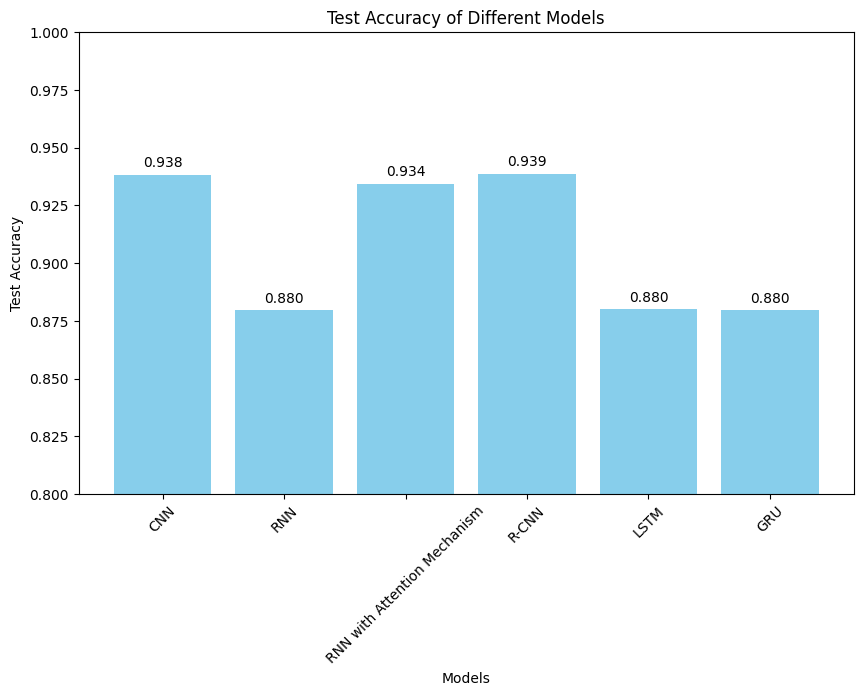

In [28]:
import matplotlib.pyplot as plt

# Accuracy values for different models
models = ['CNN', 'RNN', 'RNN with Attention Mechanism', 'R-CNN', 'LSTM', 'GRU']
accuracies = [0.9383202195167542, 0.8797025084495544, 0.93438321352005, 0.9387576580047607, 0.8801400065422058, 0.8797025084495544]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')

# Adding title and labels
plt.title('Test Accuracy of Different Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0.8, 1)  # Setting the y-axis limit for better visualization
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Adding accuracy values on top of the bars
for i in range(len(models)):
    plt.text(i, accuracies[i] + 0.002, f'{accuracies[i]:.3f}', ha='center', va='bottom')

# Displaying the plot
plt.show()
